<a href="https://colab.research.google.com/github/kt1156/Chest-X-Rays-CNN/blob/main/ChestXrays_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports + setup

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import files
files.upload() # authenticate api token

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:19<00:00, 64.3MB/s]
100% 2.29G/2.29G [00:19<00:00, 129MB/s] 


In [3]:
# unzip file
!unzip chest-xray-pneumonia.zip -d chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/chest_xray/train

In [9]:
!ls /content/chest_xray

# move contents to outer folder
!mv /content/chest_xray/chest_xray/* /content/chest_xray/

# remove any old __MACOSX folder
!rm -rf /content/chest_xray/__MACOSX

# check result
!ls /content/chest_xray

chest_xray
mv: cannot move '/content/chest_xray/chest_xray/chest_xray' to '/content/chest_xray/chest_xray': Directory not empty
chest_xray  test  train  val


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# data transforms
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# load datasets
train_data = datasets.ImageFolder("/content/chest_xray/train", transform=transform)
val_data   = datasets.ImageFolder("/content/chest_xray/val", transform=transform)
test_data  = datasets.ImageFolder("/content/chest_xray/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Batches → Train:", len(train_loader), " Val:", len(val_loader), " Test:", len(test_loader))

Using device: cuda
Batches → Train: 163  Val: 1  Test: 20


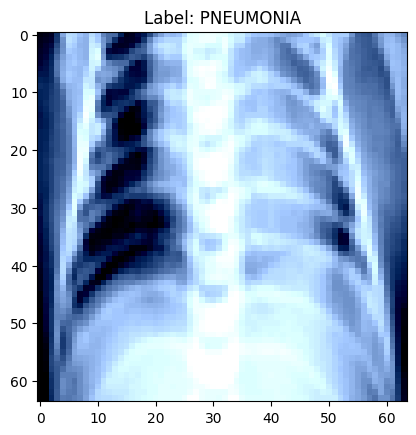

In [30]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0))  # C,H,W -> H,W,C
plt.title(f"Label: {train_data.classes[labels[0]]}")
plt.show()

In [33]:
# Model
class XrayCNN(nn.Module):
    def __init__(self):
        super(XrayCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# initalise model
model = XrayCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(epochs):
    # training
    model.train()
    running_loss, running_corrects = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    val_loss_epoch = val_loss / len(val_loader.dataset)
    val_acc_epoch = val_corrects.double() / len(val_loader.dataset)

    # store metrics
    train_losses.append(epoch_loss)
    val_losses.append(val_loss_epoch)
    train_accs.append(epoch_acc.item())
    val_accs.append(val_acc_epoch.item())

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.4f}")

# Evaluation
model.eval()
test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"\n Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/30 | Train Loss: 0.2034, Train Acc: 0.9178 | Val Loss: 0.4208, Val Acc: 0.6875
Epoch 2/30 | Train Loss: 0.0961, Train Acc: 0.9649 | Val Loss: 0.6056, Val Acc: 0.6875
Epoch 3/30 | Train Loss: 0.0739, Train Acc: 0.9724 | Val Loss: 0.3526, Val Acc: 0.8750
Epoch 4/30 | Train Loss: 0.0647, Train Acc: 0.9776 | Val Loss: 0.1828, Val Acc: 0.9375
Epoch 5/30 | Train Loss: 0.0485, Train Acc: 0.9826 | Val Loss: 0.8929, Val Acc: 0.6250
Epoch 6/30 | Train Loss: 0.0469, Train Acc: 0.9816 | Val Loss: 1.0050, Val Acc: 0.7500
Epoch 7/30 | Train Loss: 0.0362, Train Acc: 0.9860 | Val Loss: 1.2000, Val Acc: 0.6875
Epoch 8/30 | Train Loss: 0.0233, Train Acc: 0.9906 | Val Loss: 0.2486, Val Acc: 0.8125
Epoch 9/30 | Train Loss: 0.0264, Train Acc: 0.9908 | Val Loss: 1.5997, Val Acc: 0.5625
Epoch 10/30 | Train Loss: 0.0246, Train Acc: 0.9914 | Val Loss: 0.5411, Val Acc: 0.8125
Epoch 11/30 | Train Loss: 0.0101, Train Acc: 0.9973 | Val Loss: 0.7185, Val Acc: 0.7500
Epoch 12/30 | Train Loss: 0.0263, Train A

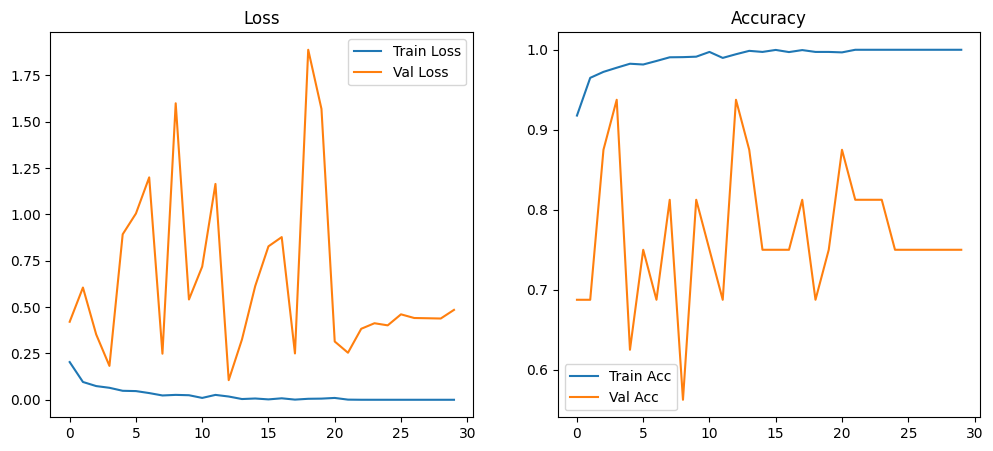

In [34]:
# Plot curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend(); plt.title("Accuracy")

plt.show()